# Reduced-rank regression analysis

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import matplotlib
import pickle
import scipy
import time
import warnings

import rnaseqTools

# pip install glmnet_py
import sparseRRR

def sns_styleset():
    sns.set(context='paper', style='ticks', font='DejaVu Sans')
    matplotlib.rcParams['axes.linewidth']    = .5
    matplotlib.rcParams['xtick.major.width'] = .5
    matplotlib.rcParams['ytick.major.width'] = .5
    matplotlib.rcParams['xtick.major.size'] = 2
    matplotlib.rcParams['ytick.major.size'] = 2
    matplotlib.rcParams['xtick.minor.size'] = 1
    matplotlib.rcParams['ytick.minor.size'] = 1
    matplotlib.rcParams['font.size']       = 6
    matplotlib.rcParams['axes.titlesize']  = 6
    matplotlib.rcParams['axes.labelsize']  = 6
    matplotlib.rcParams['legend.fontsize'] = 6
    matplotlib.rcParams['xtick.labelsize'] = 6
    matplotlib.rcParams['ytick.labelsize'] = 6
    matplotlib.rcParams['figure.dpi'] = 120

sns_styleset()

In [2]:
from collections import namedtuple
houstonData = namedtuple('houstonData', 'exonCounts intronCounts cells genes layers cre yields traced \
                                         depth thickness ephys ephysNames exclude \
                                         mice_ages mice_cres morphometrics morphometricsNames zProfiles \
                                         exonLengths intronLengths')
m1 = pickle.load(open('../data/processed/rnaseq/m1.pickle', 'rb'))
ttypes = pickle.load(open('../data/processed/rnaseq/ttypes.pickle', 'rb'))

# M1 cluster colors and names
m1data = pickle.load(open('../data/processed/reduced-allen-data/SmartSeq_cells_AIBS.pickle', 'rb'))
clusterColors = m1data['neurons']['clusterColors']
clusterNames = m1data['neurons']['clusterNames']
clusterN = clusterNames.size

In [141]:
features_exclude = ['Afterdepolarization (mV)', 'AP Fano factor', 'ISI Fano factor', 
                    'Latency @ +20pA current (ms)', 'Wildness', 'Spike frequency adaptation',
                    'Sag area (mV*s)', 'Sag time (s)', 'Burstiness',
                    'AP amplitude average adaptation index', 'ISI average adaptation index',
                    'Rebound number of APs']
features_log =     ['AP coefficient of variation', 'ISI coefficient of variation', 'ISI adaptation index']

ephysY = m1.ephys.copy()
for e in features_log:
    ephysY[:, m1.ephysNames==e] = np.log(ephysY[:, m1.ephysNames==e])
ephysY = ephysY[:, ~np.isin(m1.ephysNames, features_exclude)]

print(ephysY.shape)

(1329, 17)


Chosen offset: 7.59


<IPython.core.display.Javascript object>


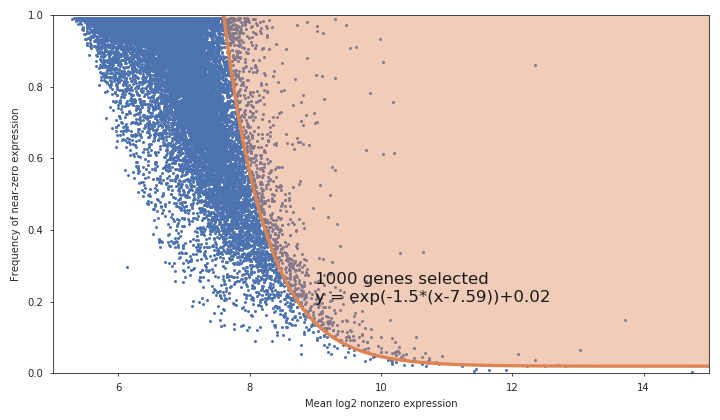

In [142]:
selection = ~np.isnan(np.sum(ephysY, axis=1)) & (m1.exclude=='') & (ttypes['type']!='')

genesForRRR  = rnaseqTools.geneSelection(m1.exonCounts[selection,:], n=1000, threshold=32, decay=1.5)

In [143]:
X =  m1.exonCounts[selection,:] / m1.exonLengths
X += m1.intronCounts[selection,:] / (m1.intronLengths + 0.001)
X /= np.sum(X, axis=1)
X *= 1e+6
X = X[:, genesForRRR]

X = np.array(X)
X = np.log2(X + 1)
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

Y = ephysY[selection,:] - np.mean(ephysY[selection,:], axis=0)
Y = Y / np.std(Y, axis=0)

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

Shape of X: (1219, 1000) 
Shape of Y: (1219, 17)


In [144]:
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=5, lambdau=.5, alpha=1)

print(m1.genes[genesForRRR][np.where(w[:,0]!=0)[0]])
print(np.sum(w[:,0]!=0))

['Arpp21' 'Bcan' 'Bdnf' 'Cacna1e' 'Cacna2d1' 'Cacna2d3' 'Coro6' 'Erbb4'
 'Gabrd' 'Gad1' 'Galnt14' 'Htr3a' 'Kcnip2' 'Lamp5' 'Mybpc1' 'Nxph1'
 'Pde1a' 'Ptk2b' 'Pvalb' 'Slc6a1' 'Sst' 'Synpr' 'Tac1' 'Tafa1' 'Vip']
25


In [7]:
shortEphysLabels = {'AP Fano factor': 'AP FF',
                    'AP amplitude (mV)': 'AP amp',
                    'AP amplitude adaptation index': 'AP amp AI',
                    'AP amplitude average adaptation index': 'AP amp AI_m',
                    'AP coefficient of variation': 'AP CV',
                    'AP threshold (mV)': 'AP thresh',
                    'AP width (ms)': 'AP width',
                    'Afterdepolarization (mV)': 'ADP',
                    'Afterhyperpolarization (mV)': 'AHP',
                    'Burstiness': 'Burst',
                    'ISI Fano factor': 'ISI FF',
                    'ISI adaptation index': 'ISI AI',
                    'ISI average adaptation index': 'ISI AI_m',
                    'ISI coefficient of variation': 'ISI CV',
                    'Input resistance (MOhm)': 'R_input',
                    'Latency (ms)': 'Latency',
                    'Max number of APs': 'Max AP num',
                    'Membrane time constant (ms)': 'Tau',
                    'Rebound (mV)': 'Rebound',
                    'Resting membrane potential (mV)': 'V_rest',
                    'Rheobase (pA)': 'Rheobase',
                    'Sag area (mV*s)': 'Sag area',
                    'Sag ratio': 'Sag',
                    'Sag time (s)': 'Sag time',
                    'Spike frequency adaptation': 'SFA',
                    'Upstroke-to-downstroke ratio': 'UDR',
                    'Wildness': 'Wildness'}

In [8]:
def adjustlabels(fig, labels, max_iter=1000, eps=0.01, delta=0.1, 
                 clip_to_axes=True, pad=0.1):
    N = len(labels)
    widths = np.zeros(N)
    heights = np.zeros(N)
    centers = np.zeros((N, 2))
    for i,l in enumerate(labels):
        bb = l.get_window_extent(renderer=fig.canvas.get_renderer())
        bb = bb.transformed(plt.gca().transData.inverted())
        widths[i] = bb.width
        heights[i] = bb.height
        centers[i] = (bb.min + bb.max)/2
        
    ylim = plt.gca().get_ylim()
    xlim = plt.gca().get_xlim()    

    def clip():
        for i in range(N):
            centers[i,0] = max(centers[i,0], xlim[0] + widths[i]/2 + pad)
            centers[i,0] = min(centers[i,0], xlim[1] - widths[i]/2 - pad)
            centers[i,1] = max(centers[i,1], ylim[0] + heights[i]/2 + pad)
            centers[i,1] = min(centers[i,1], ylim[1] - heights[i]/2 - pad)
            labels[i].set_position(centers[i])
    clip()

    for i in range(max_iter):
        stop = True
        for a in range(N):
            for b in range(N):
                if ((a!=b) and
                    (np.abs(centers[a,0]-centers[b,0]) < (widths[a]+widths[b])/2 + delta) and
                    (np.abs(centers[a,1]-centers[b,1]) < (heights[a]+heights[b])/2 +  delta)):
                    
                    d = centers[a] - centers[b]
                    centers[a] += d * eps
                    centers[b] -= d * eps
                    labels[a].set_position(centers[a])
                    labels[b].set_position(centers[b])
                    if clip_to_axes:
                        clip()
                    stop = False
        if stop:
            break    

<IPython.core.display.Javascript object>


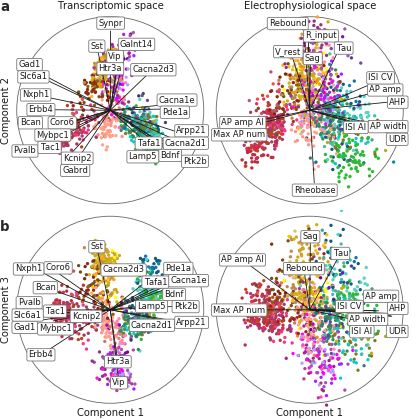

In [146]:
fig = plt.figure(figsize=(3.5, 3.5))

L = 3.2
scaleFactor = 3
s = 4
width = .475
col = clusterColors[ttypes['m1consensus_ass'][selection].astype(int)]
labelslabels = [m1.genes[genesForRRR], 
                [shortEphysLabels[e] for e in m1.ephysNames if e not in features_exclude]]

for row, components in enumerate([[0,1], [0,2]]):

    Zx = X @ w[:,components]
    Zy = Y @ v[:,components]
    Zx = Zx / np.std(Zx, axis=0)
    Zy = Zy / np.std(Zy, axis=0)

    for column, (Z,F,wv,labels) in enumerate(zip([Zx,Zy], [X,Y], [w,v], labelslabels)):
    
        plt.axes([column*width+(1-2*width)/2, .5-row*width, width, width])
        plt.scatter(Z[:,0], Z[:,1], c=col, s=s, edgecolors='none')
        plt.xticks([])
        plt.yticks([])
        plt.xlim([-L,L])
        plt.ylim([-L,L])
        Rho = np.corrcoef(np.concatenate((Z[:,:2], F), axis=1), rowvar=False)[2:,:2]
        shownlabels = []
        for i in np.where(wv[:,0]!=0)[0]:
            if np.sqrt(np.sum(Rho[i,:]**2)) > .4:
                plt.plot([0, scaleFactor*Rho[i,0]], [0, scaleFactor*Rho[i,1]], 
                         linewidth=.5, color='k', zorder=1)
                l = plt.text(scaleFactor*Rho[i,0]*1.1, scaleFactor*Rho[i,1]*1.1, labels[i],
                     ha='center', va='center', color='k', fontsize=5, zorder=10,
                     bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
                shownlabels.append(l)
        
        adjustlabels(fig, shownlabels)
        circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5, zorder=-1)
        plt.gca().add_patch(circ)

plt.gcf().text((1-2*width)/2+width/2, .978, 'Transcriptomic space', ha='center', fontsize=6, color='k')
plt.gcf().text(.5+width/2, .978, 'Electrophysiological space', ha='center', fontsize=6, color='k')
plt.gcf().text((1-2*width)/2+width/2, .01, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(.5+width/2, .01, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(.002, .5+width/2, 'Component 2', va='center', fontsize=6, color='k', rotation=90)
plt.gcf().text(.002, (1-2*width)/2+width/2, 'Component 3', va='center', fontsize=6, color='k', rotation=90)

fig.text(0,  1,  'a', fontsize=8, fontweight='bold', va='top')
fig.text(0, .45,  'b', fontsize=8, fontweight='bold')
        
sns.despine(left=True, bottom=True)

plt.savefig('../figures/mainfigures/rrr.png', dpi=300)
plt.savefig('../figures/mainfigures/pdf/rrr.pdf')

## Boostrap gene selection

In [12]:
%%time

w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=5, lambdau=.5, alpha=1)

bootCounts = sparseRRR.elastic_rrr_bootstrap(X, Y, rank=5, lambdau=.5, alpha=1, nrep=100)

.................................................................................................... 
CPU times: user 5min, sys: 3.07 s, total: 5min 3s
Wall time: 1min 15s


In [13]:
args = np.argsort(bootCounts)[::-1]
for i in range(25):
    print('{:10} {:.2f}'.format(m1.genes[genesForRRR][args[i]],
                                bootCounts[args[i]]), end='')
    if ~np.isclose(w[args[i],0],0):
        print('  *')
    else:
        print('')

Lamp5      1.00  *
Cacna2d1   1.00  *
Pvalb      1.00  *
Sst        1.00  *
Gad1       1.00  *
Synpr      1.00  *
Vip        0.99  *
Erbb4      0.99  *
Ptk2b      0.96  *
Arpp21     0.94  *
Nxph1      0.87  *
Slc6a1     0.78  *
Coro6      0.77  *
Bdnf       0.73  *
Tac1       0.72  *
Htr3a      0.65  *
Tafa1      0.58  *
Mybpc1     0.58  *
Bcan       0.56  *
Pde1a      0.53  *
Gabrd      0.45  *
Kcnip2     0.45  *
Unc13c     0.44
Galnt14    0.44  *
Plch2      0.43


## Cross-validation

In [48]:
lambdas = np.array([.45])
alphas = np.array([1])

r2, r2_relaxed, nonzero, corrs, corrs_relaxed = sparseRRR.elastic_rrr_cv(
    X, Y, rank=5, reps=1, folds=10, alphas=alphas, lambdas=lambdas)

print('R2: {:.2f}, corrs: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(
    np.mean(r2_relaxed), *np.mean(corrs_relaxed,axis=0).squeeze()))

1.......... Time: 0.0h  0m  4s
R2: 0.38, corrs: 0.90, 0.74, 0.67, 0.41, 0.29


In [49]:
%%time

lambdas = np.concatenate((np.arange(.2,1.01,.1), np.arange(2,7)))
alphas = np.array([.5, .75, 1])

cvresults = sparseRRR.elastic_rrr_cv(X, Y, rank=5, reps=1, folds=10, alphas=alphas, lambdas=lambdas)

lambdas = np.arange(.2,1,.1)
alphas = np.array([1])
ranks = np.arange(1, Y.shape[1]+1)

cvresults_rank = {}
for r in ranks:
    cvresults_rank[r] = sparseRRR.elastic_rrr_cv(X, Y, rank=r, reps=1, folds=10, alphas=alphas, lambdas=lambdas)
    
pickle.dump([cvresults, cvresults_rank], open('../data/processed/rnaseq/cvresults.pickle', 'wb'))

1.......... Time: 0.0h  4m  4s
1.......... Time: 0.0h  0m 17s
1.......... Time: 0.0h  0m 20s
1.......... Time: 0.0h  0m 36s
1.......... Time: 0.0h  0m 41s
1.......... Time: 0.0h  0m 45s
1.......... Time: 0.0h  2m  8s
1.......... Time: 0.0h  1m 18s
1.......... Time: 0.0h  2m 30s
1.......... Time: 0.0h  2m 20s
1.......... Time: 0.0h  2m  9s
1.......... Time: 0.0h  1m 27s
1.......... Time: 0.0h  2m 16s
1.......... Time: 0.0h  1m 46s
1.......... Time: 0.0h  1m 28s
1.......... Time: 0.0h  1m 58s
1.......... Time: 0.0h  1m  9s
1.......... Time: 0.0h  0m 45s
CPU times: user 1h 31min 13s, sys: 41.6 s, total: 1h 31min 55s
Wall time: 27min 58s


<IPython.core.display.Javascript object>


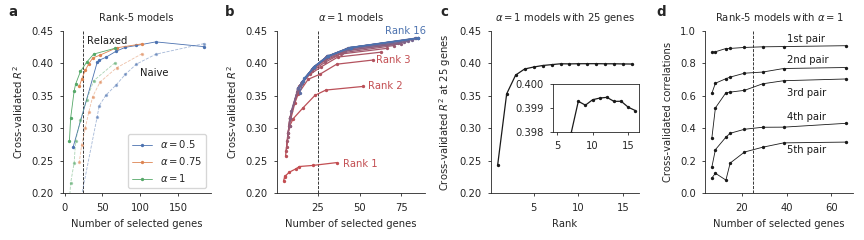

In [15]:
cvresults, cvresults_rank = pickle.load(open('../data/processed/rnaseq/cvresults.pickle', 'rb'))

r2, r2_relaxed, nonzeros, corrs, corrs_relaxed = cvresults
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    nonzeros = np.nanmean(nonzeros, axis=(0,1))
    r2_relaxed = np.nanmean(r2_relaxed, axis=(0,1))
    r2 = np.nanmean(r2, axis=(0,1))
    corrs_relaxed = np.nanmean(corrs_relaxed, axis=(0,1))

fig = plt.figure(figsize=(7.2, 2))
plt.subplot(141)
plt.plot(nonzeros, r2_relaxed, '.-', linewidth=.5, markersize=2)
plt.gca().set_prop_cycle(None)
plt.plot(nonzeros, r2, '.--', linewidth=.5, alpha=.5, markersize=2)
plt.xlabel('Number of selected genes')
plt.ylabel('Cross-validated $R^2$')
plt.ylim([.2,.45])
plt.legend(['$\\alpha='+str(a)+'$' for a in [.5, .75, 1]])
plt.plot([25,25],[.2,.45],'k--', linewidth=.5, zorder=0)
plt.title('Rank-5 models')
plt.text(100, .38, 'Naive', color='k', fontsize=6)
plt.text(30, .43, 'Relaxed', color='k', fontsize=6)

plt.subplot(144)
for k in range(corrs_relaxed.shape[2]):
    plt.plot(nonzeros[:,2], corrs_relaxed[:,2,k].squeeze(), 'k.-', linewidth=.5, markersize=2)
plt.xlabel('Number of selected genes')
plt.ylabel('Cross-validated correlations')
plt.ylim([0,1])
plt.title(r'Rank-5 models with $\alpha=1$')
plt.plot([25,25],[0,1],'k--', linewidth=.5, zorder=0)
for i,c in zip(['1st','2nd','3rd','4th','5th'], [.93,.8,.6,.45,.25]):
    plt.text(40, c, '{} pair'.format(i), color='k', fontsize=6)

plt.subplot(142)
maxRank = len(cvresults_rank)
colA = np.array([76, 114, 176]) / 256
colB = np.array([196, 78, 82])  / 256
perf25 = np.zeros(maxRank+1)
for rank in range(1,maxRank+1):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        n = np.nanmean(cvresults_rank[rank][2], axis=(0,1))
        c = np.nanmean(cvresults_rank[rank][0], axis=(0,1))
        cr = np.nanmean(cvresults_rank[rank][1], axis=(0,1))
        f = scipy.interpolate.interp1d(n.squeeze(), cr.squeeze(), kind='linear')
        perf25[rank] = f(25)
    col = (colA * (rank-1)/(maxRank-1) + colB * (maxRank-rank)/(maxRank-1))
    plt.plot(n[:,0], cr[:,0], '.-', color=col, linewidth=.75, markersize=2)
plt.ylim([.2,.45])
plt.xlabel('Number of selected genes')
plt.ylabel('Cross-validated $R^2$')
plt.plot([25,25],[.2,.45],'k--', linewidth=.5, zorder=0)
plt.text(40, .24, 'Rank 1', color=colB, fontsize=6)
plt.text(55, .36, 'Rank 2', color=colB, fontsize=6)
plt.text(60, .40, 'Rank 3', color=colB, fontsize=6)
plt.text(65, .445, 'Rank 16', color=colA, fontsize=6)
plt.title(r'$\alpha=1$ models')

plt.subplot(143)
plt.plot(np.arange(1,maxRank+1), perf25[1:], 'k.-', linewidth=.75, markersize=2)
plt.xlabel('Rank')
plt.ylabel('Cross-validated $R^2$ at 25 genes')
plt.ylim([.2,.45])
plt.title(r'$\alpha=1$ models with 25 genes')

sns.despine()
plt.tight_layout()

ax = plt.axes([.64,.45,.1,.2])
plt.plot(np.arange(5,maxRank+1), perf25[5:], 'k.-', linewidth=.75, markersize=2)
plt.ylim([.398,.4])

fig.text(.01, .98,  'a', fontsize=8, fontweight='bold', va='top')
fig.text(.26, .98,  'b', fontsize=8, fontweight='bold', va='top')
fig.text(.51, .98,  'c', fontsize=8, fontweight='bold', va='top')
fig.text(.76, .98,  'd', fontsize=8, fontweight='bold', va='top')

plt.savefig('../figures/suppfigures/rrr-cv.png', dpi=300)
plt.savefig('../figures/suppfigures/pdf/rrr-cv.pdf')

# Ion channel genes only

In [106]:
import pandas as pd
ionchannelgenes = pd.read_csv('../data/ion-channel-genes-group-177.csv')['Approved symbol'].values
print(ionchannelgenes.size)

selection = ~np.isnan(np.sum(ephysY, axis=1)) & (m1.exclude=='') & (ttypes['type']!='')

genesForRRR = np.array([m.upper() in ionchannelgenes for m in m1.genes]) & \
              np.array((np.sum(m1.exonCounts[selection,:]+
                               m1.intronCounts[selection,:]>0,axis=0)>=10)).squeeze()

X =  m1.exonCounts[selection,:] / m1.exonLengths
X += m1.intronCounts[selection,:] / (m1.intronLengths + 0.001)
X /= np.sum(X, axis=1)
X *= 1e+6
X = X[:, genesForRRR]

X = np.array(X)
X = np.log2(X + 1)
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

Y = m1.ephys.copy()
for e in features_log:
    Y[:, m1.ephysNames==e] = np.log(Y[:, m1.ephysNames==e])
Y = Y[:, ~np.isin(m1.ephysNames, features_exclude)]

Y = Y[selection,:] - np.mean(Y[selection,:], axis=0)
Y = Y / np.std(Y, axis=0)

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

328
Shape of X: (1219, 307) 
Shape of Y: (1219, 17)


In [107]:
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=5, lambdau=.303, alpha=1)

print(m1.genes[genesForRRR][np.where(w[:,0]!=0)[0]])
print(np.sum(w[:,0]!=0))

['Ano3' 'Asic4' 'Cacna1e' 'Cacna2d1' 'Cacna2d2' 'Cacna2d3' 'Cacng3'
 'Gabra1' 'Gabra2' 'Gabrd' 'Grik1' 'Grin3a' 'Hcn1' 'Htr3a' 'Itpr1' 'Kcna1'
 'Kcnc1' 'Kcnc2' 'Kcnf1' 'Kcnh4' 'Kcnh7' 'Kcnt2' 'Kcnv1' 'Scn1a' 'Scn3b']
25


In [52]:
lambdas = np.array([.303])
alphas = np.array([1])
r2, r2_relaxed, nonzero, corrs, corrs_relaxed = sparseRRR.elastic_rrr_cv(
    X, Y, rank=5, reps=1, folds=10, alphas=alphas, lambdas=lambdas)

print('R2: {:.2f}, corrs: {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(
    np.mean(r2_relaxed), *np.mean(corrs_relaxed,axis=0).squeeze()))

1.......... Time: 0.0h  0m  4s
R2: 0.33, corrs: 0.86, 0.71, 0.56, 0.28, 0.23


<IPython.core.display.Javascript object>


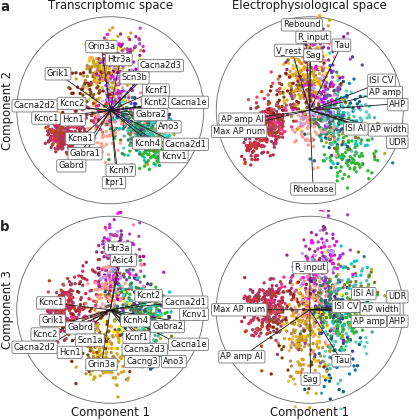

In [53]:
fig = plt.figure(figsize=(3.5, 3.5))

L = 3.2
scaleFactor = 3
s = 4
width = .475
col = clusterColors[ttypes['m1consensus_ass'][selection].astype(int)]
labelslabels = [m1.genes[genesForRRR], 
                [shortEphysLabels[e] for e in m1.ephysNames if e not in features_exclude]]
offsets = [[{},{}],[{},{}]]

for row, components in enumerate([[0,1], [0,2]]):

    Zx = X @ w[:,components]
    Zy = Y @ v[:,components]
    Zx = Zx / np.std(Zx, axis=0)
    Zy = Zy / np.std(Zy, axis=0)

    for column, (Z,F,wv,labels) in enumerate(zip([Zx,Zy], [X,Y], [w,v], labelslabels)):
    
        plt.axes([column*width+(1-2*width)/2, .5-row*width, width, width])
        plt.scatter(Z[:,0], Z[:,1], c=col, s=s, edgecolors='none')
        plt.xticks([])
        plt.yticks([])
        plt.xlim([-L,L])
        plt.ylim([-L,L])
        shownlabels = []
        Rho = np.corrcoef(np.concatenate((Z[:,:2], F), axis=1), rowvar=False)[2:,:2]
        for i in np.where(wv[:,0]!=0)[0]:
            if np.sqrt(np.sum(Rho[i,:]**2)) > .4:
                plt.plot([0, scaleFactor*Rho[i,0]], [0, scaleFactor*Rho[i,1]], 
                         linewidth=.5, color='k', zorder=1)
                dx,dy = 0,0
                if labels[i] in offsets[row][column]:
                    dx += offsets[row][column][labels[i]][0]
                    dy += offsets[row][column][labels[i]][1]
                l = plt.text(scaleFactor*Rho[i,0]*1.1 + dx, scaleFactor*Rho[i,1]*1.1 + dy, labels[i],
                     ha='center', va='center', color='k', fontsize=5, zorder=10,
                     bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
                shownlabels.append(l)

        adjustlabels(fig, shownlabels)
        circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5, zorder=-1)
        plt.gca().add_patch(circ)

plt.gcf().text((1-2*width)/2+width/2, .978, 'Transcriptomic space', ha='center', fontsize=7, color='k')
plt.gcf().text(.5+width/2, .978, 'Electrophysiological space', ha='center', fontsize=7, color='k')
plt.gcf().text((1-2*width)/2+width/2, .01, 'Component 1', ha='center', fontsize=7, color='k')
plt.gcf().text(.5+width/2, .01, 'Component 1', ha='center', fontsize=7, color='k')
plt.gcf().text(.002, .5+width/2, 'Component 2', va='center', fontsize=7, color='k', rotation=90)
plt.gcf().text(.002, (1-2*width)/2+width/2, 'Component 3', va='center', fontsize=7, color='k', rotation=90)

fig.text(0,  1,  'a', fontsize=8, fontweight='bold', va='top')
fig.text(0, .45,  'b', fontsize=8, fontweight='bold')
        
sns.despine(left=True, bottom=True)

plt.savefig('../figures/extra/rrr-ionchannels.png', dpi=300)

<IPython.core.display.Javascript object>


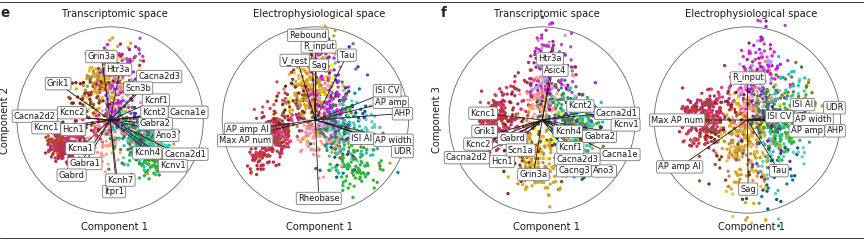

In [130]:
fig = plt.figure(figsize=(7.2, 2.0))

L = 3.2
scaleFactor = 3
s = 4
col = clusterColors[ttypes['m1consensus_ass'][selection].astype(int)]
labelslabels = [m1.genes[genesForRRR], 
                [shortEphysLabels[e] for e in m1.ephysNames if e not in features_exclude]]
offsets = [[{},{}],[{},{}]]

xx = [0.0125, 0.25, 0.5125, 0.75]

for row, components in enumerate([[0,1], [0,2]]):

    Zx = X @ w[:,components]
    Zy = Y @ v[:,components]
    Zx = Zx / np.std(Zx, axis=0)
    Zy = Zy / np.std(Zy, axis=0)

    for column, (Z,F,wv,labels) in enumerate(zip([Zx,Zy], [X,Y], [w,v], labelslabels)):
    
        plt.axes([xx[row*2+column], .05, .23, .9])
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.scatter(Z[:,0], Z[:,1], c=col, s=s, edgecolors='none')
        plt.xticks([])
        plt.yticks([])
        plt.xlim([-L,L])
        plt.ylim([-L,L])
        shownlabels = []
        Rho = np.corrcoef(np.concatenate((Z[:,:2], F), axis=1), rowvar=False)[2:,:2]
        for i in np.where(wv[:,0]!=0)[0]:
            if np.sqrt(np.sum(Rho[i,:]**2)) > .4:
                plt.plot([0, scaleFactor*Rho[i,0]], [0, scaleFactor*Rho[i,1]], 
                         linewidth=.5, color='k', zorder=1)
                dx,dy = 0,0
                if labels[i] in offsets[row][column]:
                    dx += offsets[row][column][labels[i]][0]
                    dy += offsets[row][column][labels[i]][1]
                l = plt.text(scaleFactor*Rho[i,0]*1.1 + dx, scaleFactor*Rho[i,1]*1.1 + dy, labels[i],
                     ha='center', va='center', color='k', fontsize=5, zorder=10,
                     bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
                shownlabels.append(l)

        adjustlabels(fig, shownlabels)
        circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5, zorder=-1)
        plt.gca().add_patch(circ)

plt.gcf().text(xx[0]+.24/2, .93, 'Transcriptomic space', ha='center', fontsize=6, color='k')
plt.gcf().text(xx[1]+.24/2, .93, 'Electrophysiological space', ha='center', fontsize=6, color='k')
plt.gcf().text(xx[2]+.24/2, .93, 'Transcriptomic space', ha='center', fontsize=6, color='k')
plt.gcf().text(xx[3]+.24/2, .93, 'Electrophysiological space', ha='center', fontsize=6, color='k')

plt.gcf().text(xx[0]+.24/2, .04, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(xx[1]+.24/2, .04, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(xx[2]+.24/2, .04, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(xx[3]+.24/2, .04, 'Component 1', ha='center', fontsize=6, color='k')

plt.gcf().text(.0, .5, 'Component 2', va='center', fontsize=6, color='k', rotation=90)
plt.gcf().text(.5, .5, 'Component 3', va='center', fontsize=6, color='k', rotation=90)

fig.text(0,   .93,  'e', fontsize=8, fontweight='bold')
fig.text(.51, .93,  'f', fontsize=8, fontweight='bold')
        
sns.despine(left=True, bottom=True)

plt.axes([0,0,1,1])
plt.axis('off')
plt.plot([0,1],[.01,.01], 'k', linewidth=.5, transform=plt.gca().transAxes)
plt.plot([0,1],[.99,.99], 'k', linewidth=.5, transform=plt.gca().transAxes)

plt.savefig('../figures/suppfigures/rrr-ionchannels.png', dpi=300)
plt.savefig('../figures/suppfigures/pdf/rrr-ionchannels.pdf')

## RRR to morpho

In [131]:
morphY = m1.morphometrics.copy()

selection = np.isin(ttypes['family'], ['IT', 'CT', 'NP', 'PT']) & m1.traced

print(np.sum(selection))

feat = np.sum(~np.isnan(morphY[selection,:]), axis=0) == np.sum(selection)
print(np.sum(feat))
morphY = morphY[:, feat]

genesForRRR  = rnaseqTools.geneSelection(m1.exonCounts[selection,:], n=1000, threshold=32, decay=1.5, plot=False)

235
35
Chosen offset: 7.53


In [132]:
X =  m1.exonCounts[selection,:] / m1.exonLengths
X += m1.intronCounts[selection,:] / (m1.intronLengths + 0.001)
X /= np.sum(X, axis=1)
X *= 1e+6
X = X[:, genesForRRR]

X = np.array(X)
X = np.log2(X + 1)
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

Y = morphY[selection,:] - np.mean(morphY[selection,:], axis=0)
Y = Y / np.std(Y, axis=0)

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

Shape of X: (235, 1000) 
Shape of Y: (235, 35)


In [133]:
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=5, lambdau=.59, alpha=1)

print(m1.genes[genesForRRR][np.where(w[:,0]!=0)[0]])
print(np.sum(w[:,0]!=0))

['Aldoc' 'Calb1' 'Camk2d' 'Cd2bp2' 'Cdh13' 'Deptor' 'Drd1' 'Dusp18'
 'Eif3a' 'Fkbp1a' 'Gm23153' 'Gm24105' 'Gm49948' 'Gm5826' 'Htr2a' 'Mbp'
 'Rxfp2' 'Stxbp6' 'Sulf1' 'Svil' 'Tcf4' 'Trbc2' 'Trp53i11' 'Wls' 'Ywhah']
25


In [134]:
# What's not here, will not be shown in the figure

shortMorphLabels = {'dendrite height': 'dendr H',
                    'dendrite width': 'dendr W',
                    'dendrite tips': 'dendr tips',
                    'normalized depth': 'depth',
                    'axon width': 'axon W',
                    'axon height': 'axon H',
                    'axon tips': 'axon tips',
                    'Log1p fraction of axon below dendrite': 'axon below dendr',
                    'Log1p fraction of dendrite above axon': 'dendr above axon'}

<IPython.core.display.Javascript object>


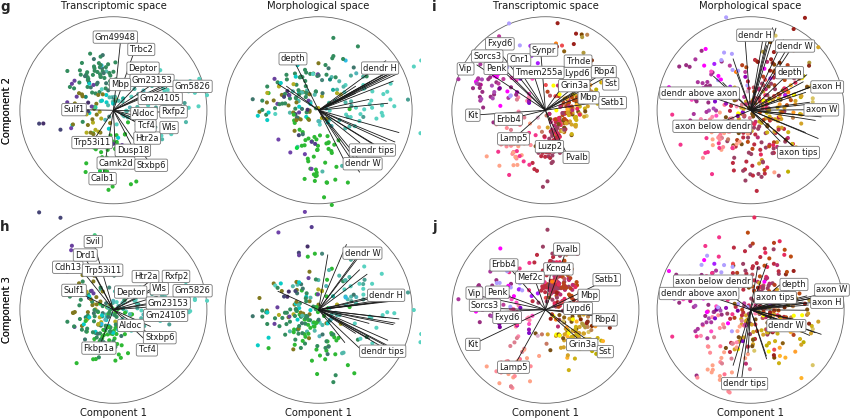

In [135]:
fig = plt.figure(figsize=(7.2, 3.5))

L = 3.2
scaleFactor = 3
s = 6
width = .475
col = clusterColors[ttypes['m1consensus_ass'][selection].astype(int)]
labelslabels = [m1.genes[genesForRRR], #m1.morphometricsNames[feat]]
               [shortMorphLabels[e] if e in shortMorphLabels else '' for e in m1.morphometricsNames[feat]]]

for row, components in enumerate([[0,1], [0,2]]):

    Zx = X @ w[:,components]
    Zy = Y @ v[:,components]
    Zx = Zx / np.std(Zx, axis=0)
    Zy = Zy / np.std(Zy, axis=0)

    for column, (Z,F,wv,labels) in enumerate(zip([Zx,Zy], [X,Y], [w,v], labelslabels)):
    
        plt.axes([column*width/2+(1-2*width)/2/2, .5-row*width, width/2, width])
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.scatter(Z[:,0], Z[:,1], c=col, s=s, edgecolors='none')
        plt.xticks([])
        plt.yticks([])
        plt.xlim([-L,L])
        plt.ylim([-L,L])
        Rho = np.corrcoef(np.concatenate((Z[:,:2], F), axis=1), rowvar=False)[2:,:2]
        shownlabels = []
        for i in np.where(wv[:,0]!=0)[0]:
            if np.sqrt(np.sum(Rho[i,:]**2)) > .4:
                plt.plot([0, scaleFactor*Rho[i,0]], [0, scaleFactor*Rho[i,1]], 
                         linewidth=.5, color='k', zorder=1)
                l = plt.text(scaleFactor*Rho[i,0], scaleFactor*Rho[i,1], labels[i],
                     ha='center', va='center', color='k', fontsize=5, zorder=10,
                     bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
                shownlabels.append(l)
        
        adjustlabels(fig, shownlabels)
        circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5, zorder=-1)
        plt.gca().add_patch(circ)

plt.gcf().text((1-2*width)/2/2+width/2/2, .978, 'Transcriptomic space', ha='center', fontsize=6, color='k')
plt.gcf().text(.5/2+width/2/2, .978, 'Morphological space', ha='center', fontsize=6, color='k')
plt.gcf().text((1-2*width)/2/2+width/2/2, .01, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(.5/2+width/2/2, .01, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(.002, .5+width/2, 'Component 2', va='center', fontsize=6, color='k', rotation=90)
plt.gcf().text(.002, (1-2*width)/2+width/2, 'Component 3', va='center', fontsize=6, color='k', rotation=90)

fig.text(0,  1,  'g', fontsize=8, fontweight='bold', va='top')
fig.text(0, .45,  'h', fontsize=8, fontweight='bold');

In [136]:
morphY = m1.morphometrics.copy()

selection = np.isin(ttypes['family'], ['Sst', 'Pvalb', 'Vip', 'Sncg', 'Lamp5']) & m1.traced
selection[np.isin(m1.cells, ['20180820_sample_1', '20180921_sample_3'])] = False

print(np.sum(selection))

feat = np.sum(~np.isnan(morphY[selection,:]), axis=0) == np.sum(selection)
print(np.sum(feat))
morphY = morphY[:, feat]

genesForRRR  = rnaseqTools.geneSelection(m1.exonCounts[selection,:], n=1000, threshold=32, decay=1.5, plot=False)

367
50
Chosen offset: 7.65


In [137]:
X =  m1.exonCounts[selection,:] / m1.exonLengths
X += m1.intronCounts[selection,:] / (m1.intronLengths + 0.001)
X /= np.sum(X, axis=1)
X *= 1e+6
X = X[:, genesForRRR]

X = np.array(X)
X = np.log2(X + 1)
X = X - np.mean(X, axis=0)
X = X / np.std(X, axis=0)

Y = morphY[selection,:] - np.mean(morphY[selection,:], axis=0)
Y = Y / np.std(Y, axis=0)

print('Shape of X:', X.shape, '\nShape of Y:', Y.shape)

Shape of X: (367, 1000) 
Shape of Y: (367, 50)


In [138]:
w,v = sparseRRR.relaxed_elastic_rrr(X, Y, rank=5, lambdau=.49, alpha=1)

print(m1.genes[genesForRRR][np.where(w[:,0]!=0)[0]])
print(np.sum(w[:,0]!=0))

['Ccl3' 'Cnr1' 'Cntnap5c' 'Dock8' 'Erbb4' 'Fxyd6' 'Grin2a' 'Grin3a'
 'Kcng4' 'Kit' 'Lamp5' 'Luzp2' 'Lypd6' 'Mbp' 'Mef2c' 'Penk' 'Pvalb' 'Rbp4'
 'Satb1' 'Sorcs3' 'Sst' 'Synpr' 'Thsd7a' 'Tmem255a' 'Trhde' 'Vip']
26


In [139]:
L = 3.2
scaleFactor = 3
s = 6
width = .475
col = clusterColors[ttypes['m1consensus_ass'][selection].astype(int)]
labelslabels = [m1.genes[genesForRRR], #m1.morphometricsNames[feat]]
               [shortMorphLabels[e] if e in shortMorphLabels else '' for e in m1.morphometricsNames[feat]]]

for row, components in enumerate([[0,1], [0,2]]):

    Zx = X @ w[:,components]
    Zy = Y @ v[:,components]
    Zx = Zx / np.std(Zx, axis=0)
    Zy = Zy / np.std(Zy, axis=0)

    for column, (Z,F,wv,labels) in enumerate(zip([Zx,Zy], [X,Y], [w,v], labelslabels)):
    
        plt.axes([.5 + column*width/2+(1-2*width)/2/2, .5-row*width, width/2, width])
        plt.gca().set_aspect('equal', adjustable='datalim')
        plt.scatter(Z[:,0], Z[:,1], c=col, s=s, edgecolors='none')
        plt.xticks([])
        plt.yticks([])
        plt.xlim([-L,L])
        plt.ylim([-L,L])
        Rho = np.corrcoef(np.concatenate((Z[:,:2], F), axis=1), rowvar=False)[2:,:2]
        shownlabels = []
        for i in np.where(wv[:,0]!=0)[0]:
            if np.sqrt(np.sum(Rho[i,:]**2)) > .4:
                plt.plot([0, scaleFactor*Rho[i,0]], [0, scaleFactor*Rho[i,1]], 
                         linewidth=.5, color='k', zorder=1)
                l = plt.text(scaleFactor*Rho[i,0], scaleFactor*Rho[i,1], labels[i],
                     ha='center', va='center', color='k', fontsize=5, zorder=10,
                     bbox=dict(facecolor='w', edgecolor='#777777', boxstyle='round', linewidth=.5, pad=.2))
                shownlabels.append(l)
        
        adjustlabels(fig, shownlabels)
        circ = plt.Circle((0,0), radius=scaleFactor, color=[.4, .4, .4], fill=False, linewidth=.5, zorder=-1)
        plt.gca().add_patch(circ)

plt.gcf().text(.5+(1-2*width)/2/2+width/2/2, .978, 'Transcriptomic space', ha='center', fontsize=6, color='k')
plt.gcf().text(.5+.5/2+width/2/2, .978, 'Morphological space', ha='center', fontsize=6, color='k')
plt.gcf().text(.5+(1-2*width)/2/2+width/2/2, .01, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(.5+.5/2+width/2/2, .01, 'Component 1', ha='center', fontsize=6, color='k')
plt.gcf().text(.002, .5+width/2, 'Component 2', va='center', fontsize=6, color='k', rotation=90)
plt.gcf().text(.002, (1-2*width)/2+width/2, 'Component 3', va='center', fontsize=6, color='k', rotation=90)

fig.text(.5,  1,  'i', fontsize=8, fontweight='bold', va='top')
fig.text(.5, .45,  'j', fontsize=8, fontweight='bold');   

In [140]:
sns.despine(left=True, bottom=True)
plt.savefig('../figures/suppfigures/rrr-morph.png', dpi=300)
plt.savefig('../figures/suppfigures/pdf/rrr-morph.pdf')